In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

os.environ["RUNFILES_DIR"] = "/Library/Frameworks/Python.framework/Versions/3.7/share/plaidml"
# plaidml might exist in different location. Look for "/usr/local/share/plaidml" and replace in above path

#os.environ["PLAIDML_NATIVE_PATH"] = "/Library/Frameworks/Python.framework/Versions/3.7/lib/libplaidml.dylib"
os.environ["PLAIDML_NATIVE_PATH"] = "/anaconda3/lib/libplaidml.dylib"
# libplaidml.dylib might exist in different location. Look for "/usr/local/lib/libplaidml.dylib" and replace in above path

In [2]:
import plaidml.keras
plaidml.keras.install_backend()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras import layers

from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam


In [4]:
train_dir = 'gan_images'



In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)

targetsize=32

batchsize=64

latent_dim=1000

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(targetsize,targetsize),
        batch_size=batchsize,
        class_mode='categorical')


Found 539 images belonging to 1 classes.


In [6]:
for data_batch, labels_batch in train_generator:
    print('data batch shape: ', data_batch.shape)
    print('labels batch shape: ', labels_batch.shape)
    break

data batch shape:  (64, 32, 32, 3)
labels batch shape:  (64, 1)


In [7]:
inputt,outputt = next(train_generator)

In [8]:
inputt.shape

(64, 32, 32, 3)

In [9]:
 inputt.shape==(batchsize,targetsize,targetsize,3)

True

In [10]:
outputt.shape

(64, 1)

In [11]:
inputt2=np.reshape(inputt,(batchsize,targetsize*targetsize*3))

In [12]:
inputt2.shape

(64, 3072)

In [13]:
# def load_data():
#     (x_train, y_train), (x_test, y_test) = mnist.load_data()
#     x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
#     # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
#     # 784 columns per row
#     x_train = x_train.reshape(60000, 784)
#     return (x_train, y_train, x_test, y_test)
# (X_train, y_train,X_test, y_test)=load_data()
# print(X_train.shape)

def adam_optimizer():
    return Adam()

In [14]:
def create_generator():
    generator=Sequential()
    
    
    n_nodes =  int(targetsize * targetsize *3 /16 )
    
    generator.add(layers.Dense(units=n_nodes,input_dim=latent_dim))
    generator.add(layers.LeakyReLU(0.2))
    generator.add(layers.Reshape((int(targetsize/4), int(targetsize/4), 3)))
  

    
    generator.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1)))
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU(alpha=0.2))
    
    generator.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1)))
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU(alpha=0.2))
    
    generator.add(layers.Conv2DTranspose(128, (3,3), strides=(1,1)))
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU(alpha=0.2))
    
    generator.add(layers.Conv2DTranspose(128, (3,3), strides=(1,1)))
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU(alpha=0.2))
    
    generator.add(layers.Conv2DTranspose(128, (2,2), strides=(1,1)))
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU(alpha=0.2))
    
    generator.add(layers.Conv2DTranspose(128, (2,2), strides=(2,2)))
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU(alpha=0.2))
    
    generator.add(layers.Conv2D(3, (11,11), activation='sigmoid'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator

g=create_generator()
g.summary()

INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 192)               192192    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 192)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 3)           0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 12, 12, 128)       9728      
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       409728    
__________

In [15]:



def create_discriminator():
    discriminator=Sequential()
    
#     discriminator.add(Dense(1024, input_dim=targetsize*targetsize*3))
#     discriminator.add(LeakyReLU(alpha=0.2))
#     discriminator.add(layers.Reshape((targetsize, targetsize, 3)))
   
    discriminator.add(layers.Conv2D(64, (5,5), activation='relu', input_shape=(targetsize,targetsize,3)))


    discriminator.add(layers.Conv2D(64, (5,5), activation='relu'))
  

    discriminator.add(layers.Conv2D(64, (5,5), activation='relu'))
   

#     discriminator.add(layers.Conv2D(32, (5,5), activation='relu'))
    
#     discriminator.add(layers.Conv2D(32, (5,5), activation='relu'))
   

    discriminator.add(layers.Conv2D(32, (7,7), activation='relu'))


    discriminator.add(layers.Flatten())
    
    #discriminator.add(layers.Dropout(0.5))

    discriminator.add(layers.Dense(32,activation='relu'))\
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator

d =create_discriminator()
d.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 64)        4864      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        102464    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 20, 64)        102464    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)        100384    
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                200736    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [16]:
 def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(create_discriminator(),create_generator())
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 32, 32, 3)         1087683   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 510945    
Total params: 1,598,628
Trainable params: 1,086,147
Non-trainable params: 512,481
_________________________________________________________________


In [17]:
def plot_generated_images(epoch, generator,  dim=(12,12), figsize=(20,20)):
    noise= np.random.normal(loc=0, scale=1, size=[batchsize, latent_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(batchsize,targetsize,targetsize,3)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    #plt.savefig('gan_generated_image %d.png' %epoch)

In [18]:

def training(epochs=1, batch_size=batchsize):
    
    
    
    #Loading the data
    # batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator=  create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in range(int(5805/batch_size)):
            if _%10==0:
                print(_/(58.05/batch_size),"%")
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, latent_dim])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # get next group of values
            inputt,outputt = next(train_generator)
            while inputt.shape!=(batch_size,targetsize,targetsize,3):
                inputt,outputt = next(train_generator)
          #  print(inputt.shape)
      
                    
           # inputt2=np.reshape(inputt,(batch_size,targetsize*targetsize*3))
            
            # Get a random set of  real images
           # print(inputt2.shape)
            image_batch = inputt
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=1.0
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
 
           
        plot_generated_images(e, generator)





Epoch 1
0.0 %


INFO:plaidml:Analyzing Ops: 821 of 1081 operations complete


11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


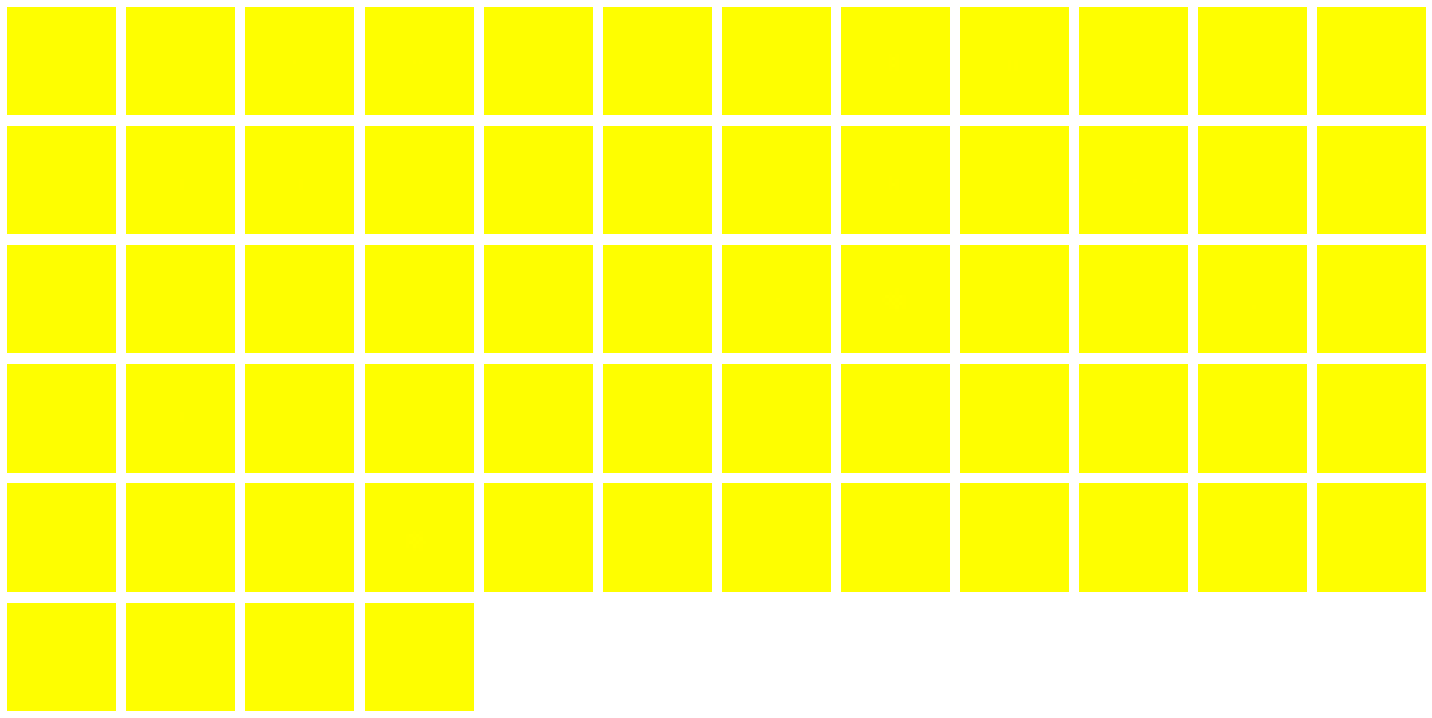

Epoch 2
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


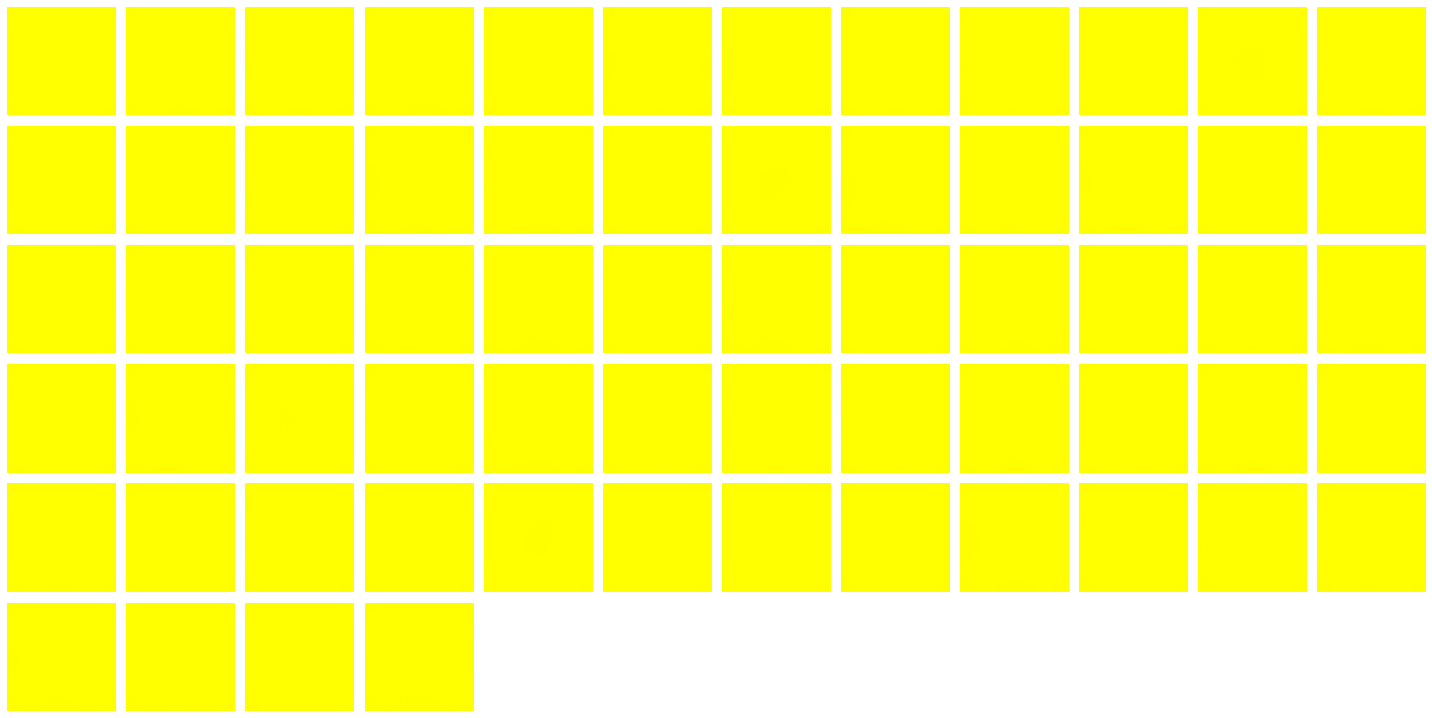

Epoch 3
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


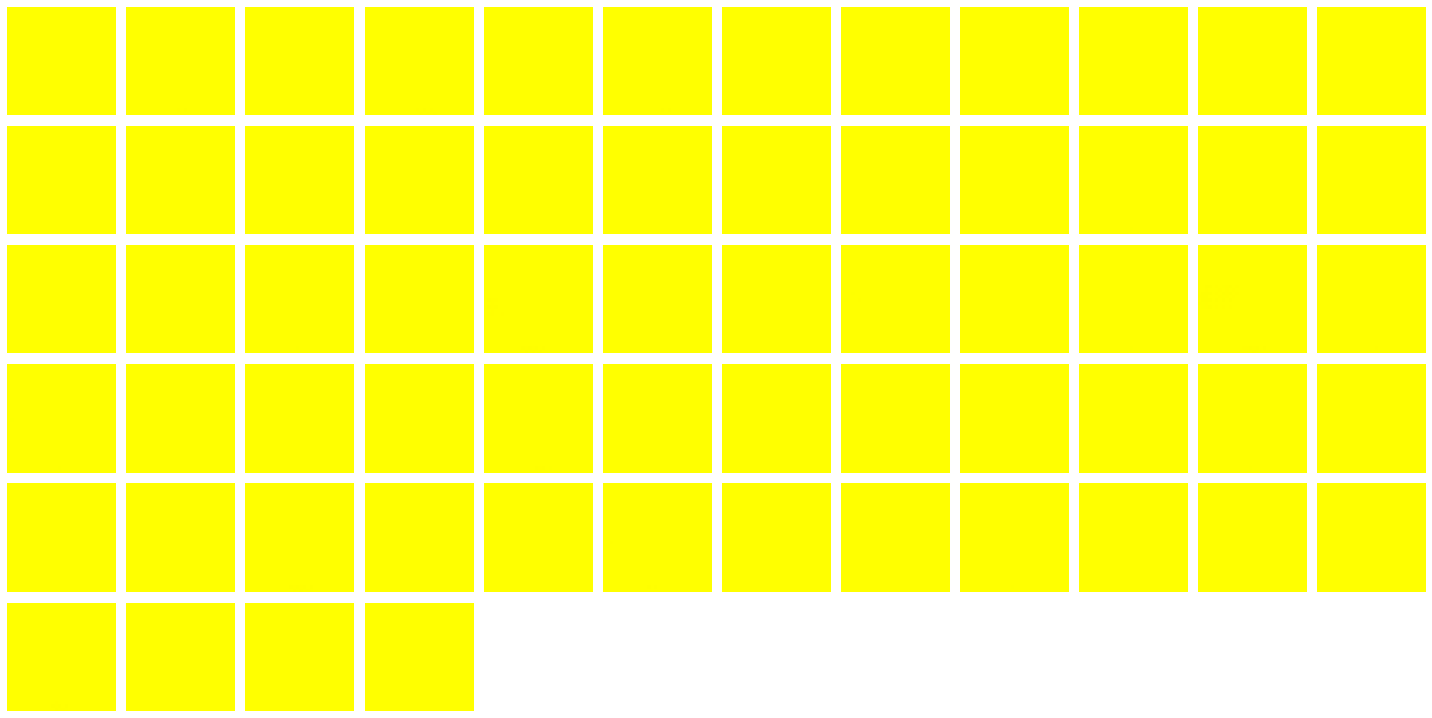

Epoch 4
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


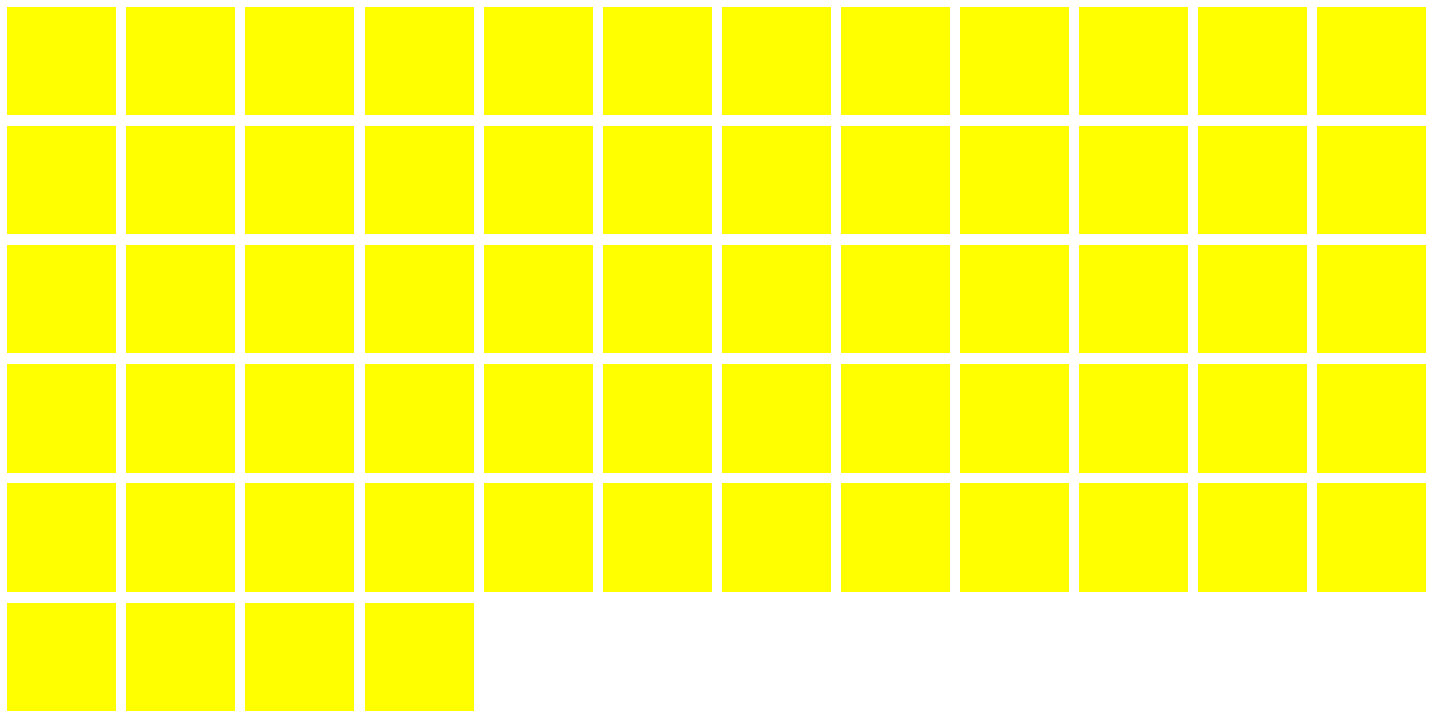

Epoch 5
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


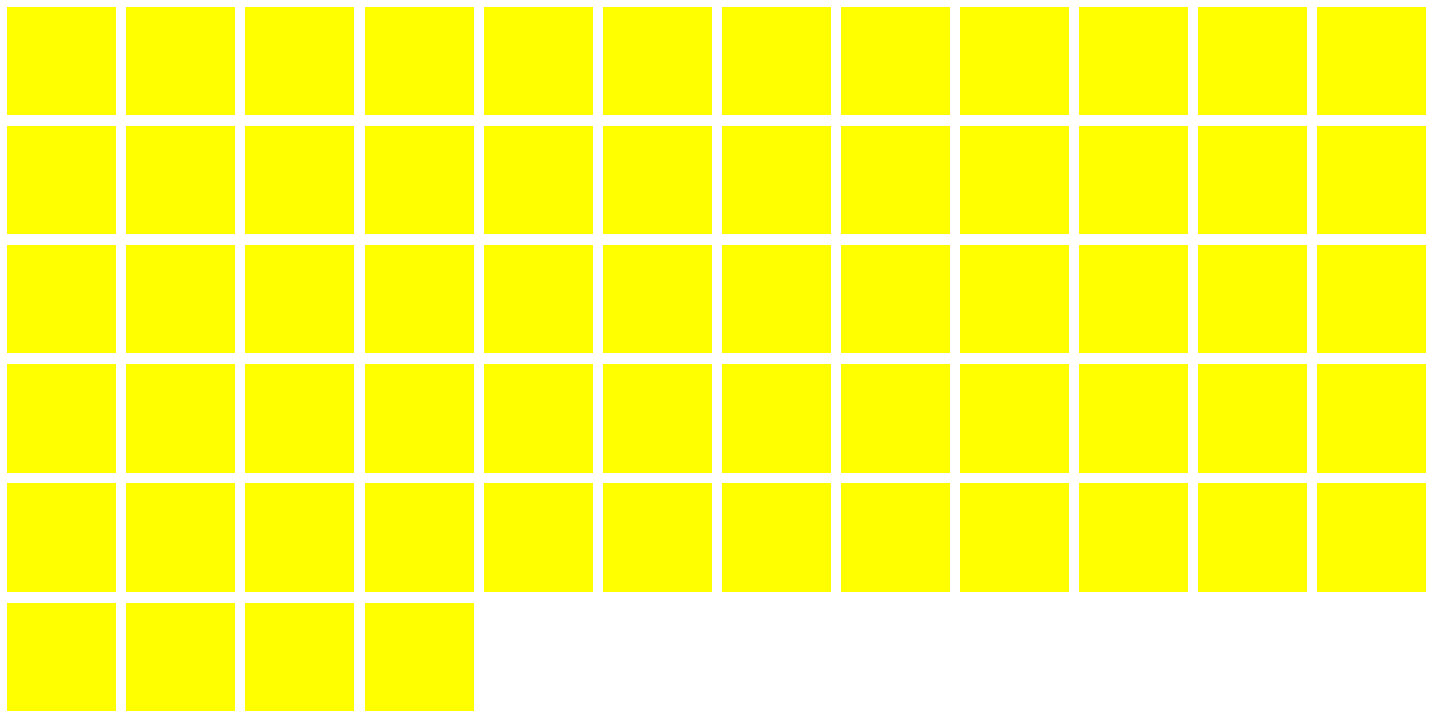

Epoch 6
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


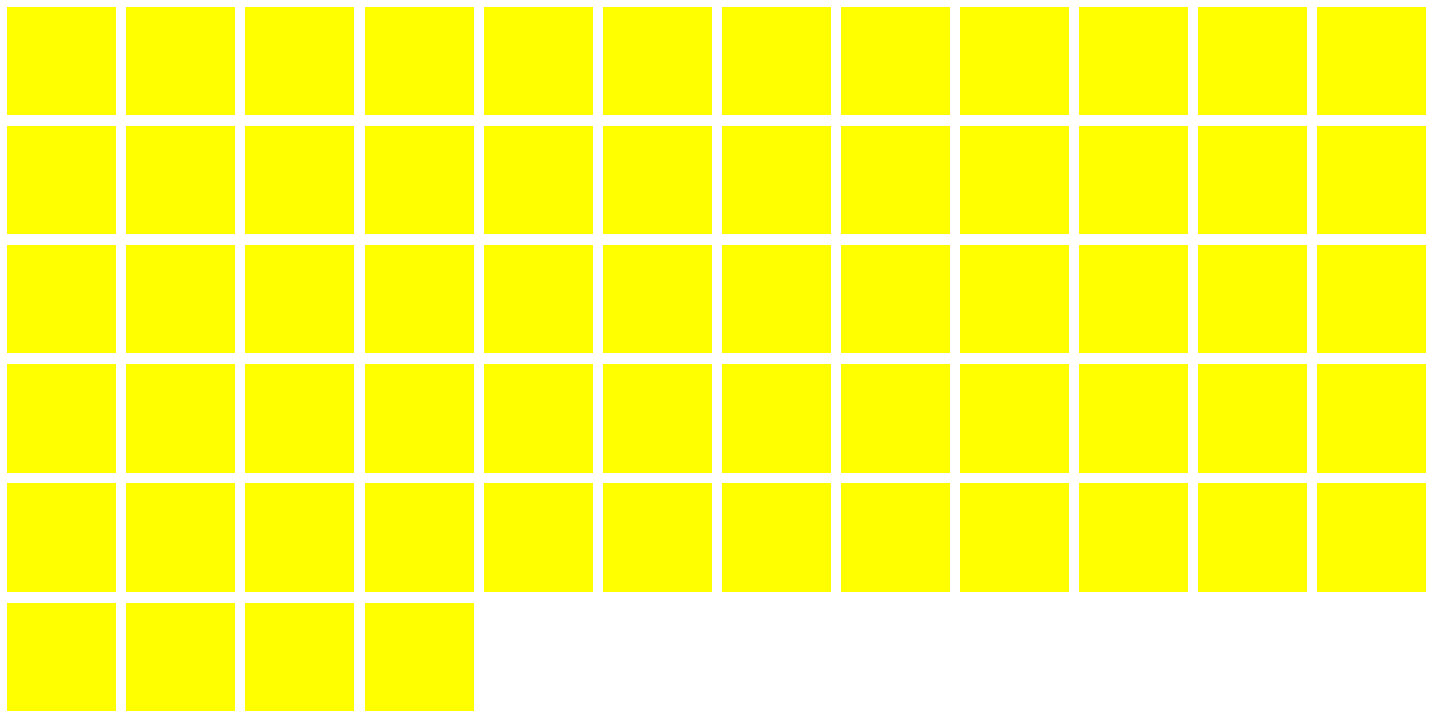

Epoch 7
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


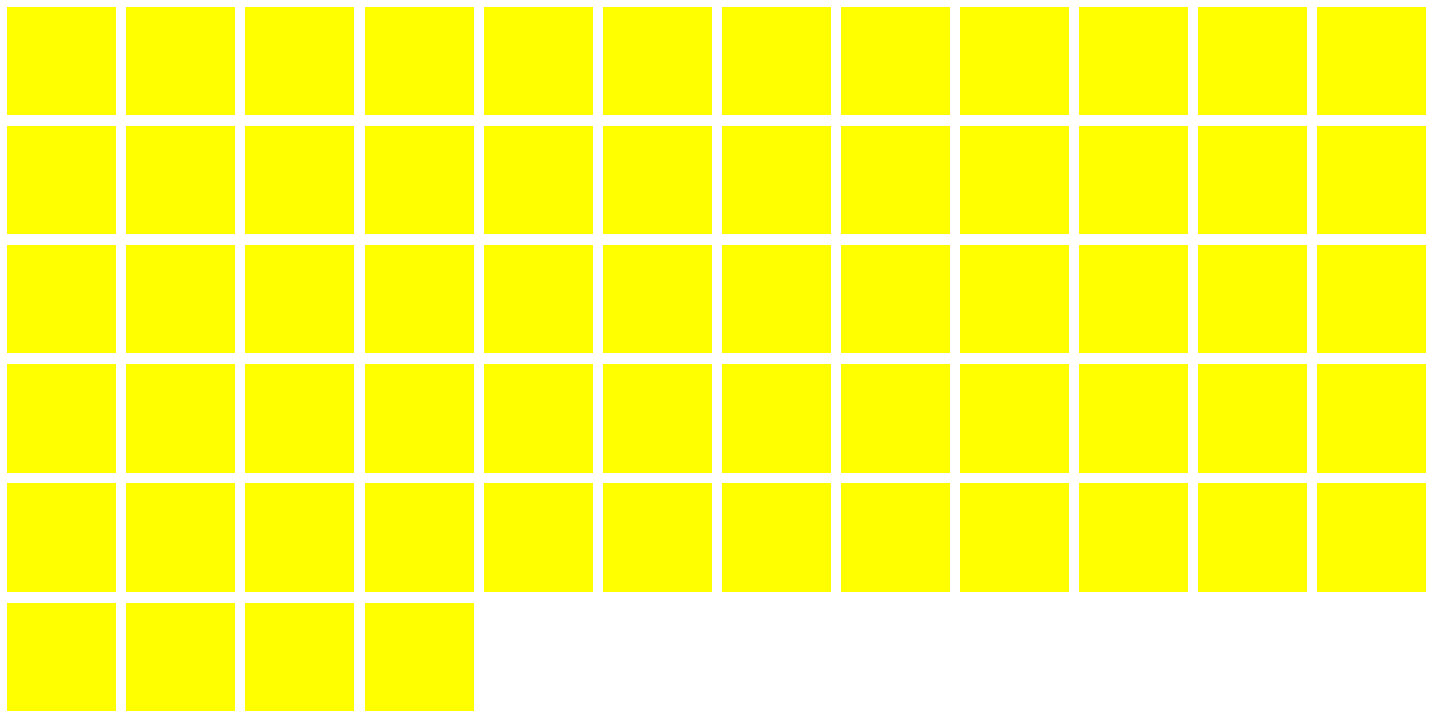

Epoch 8
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


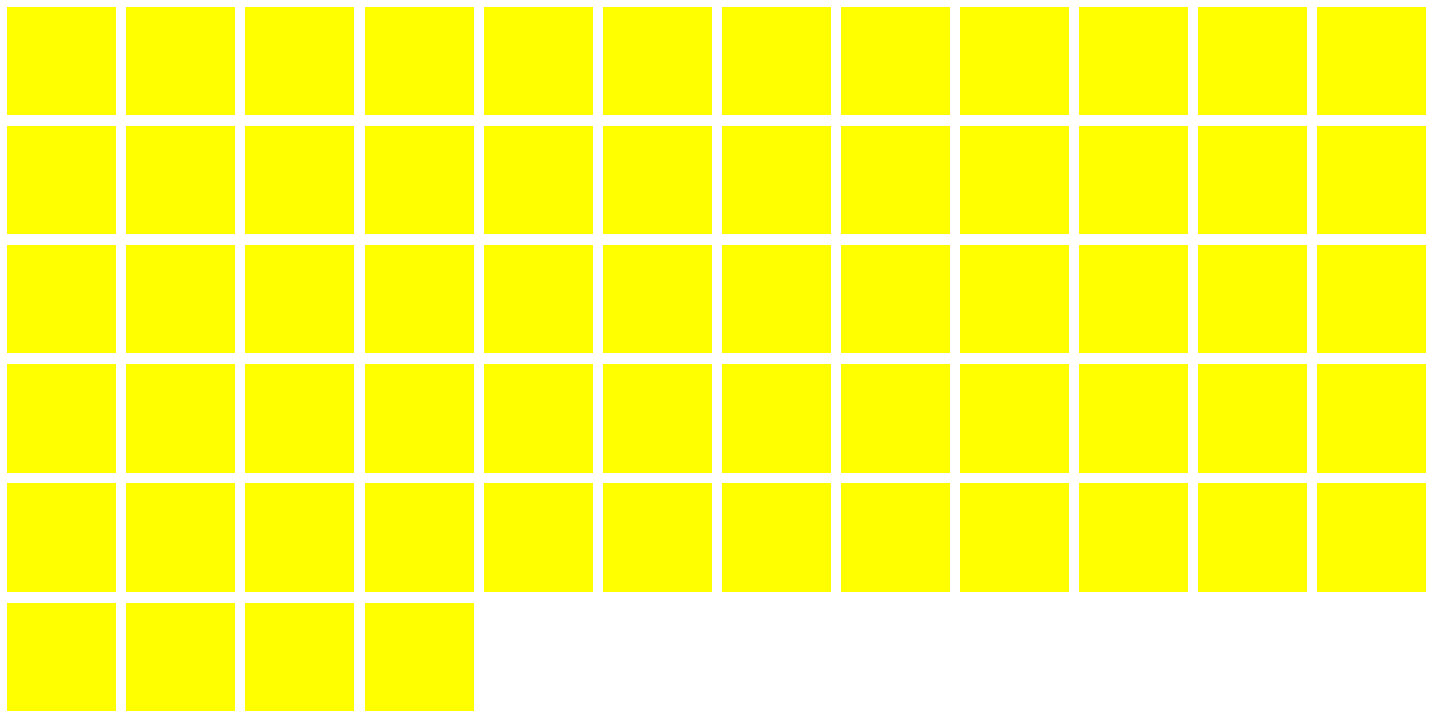

Epoch 9
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


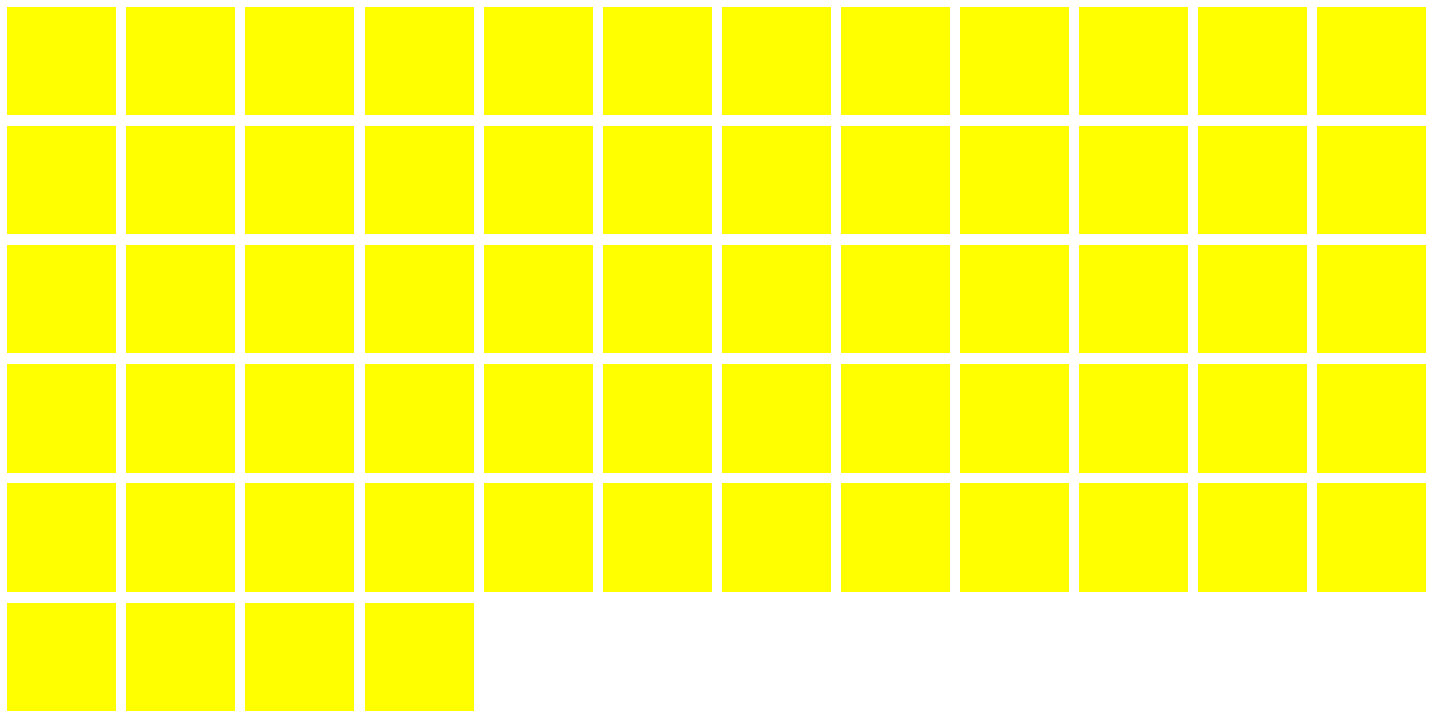

Epoch 10
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


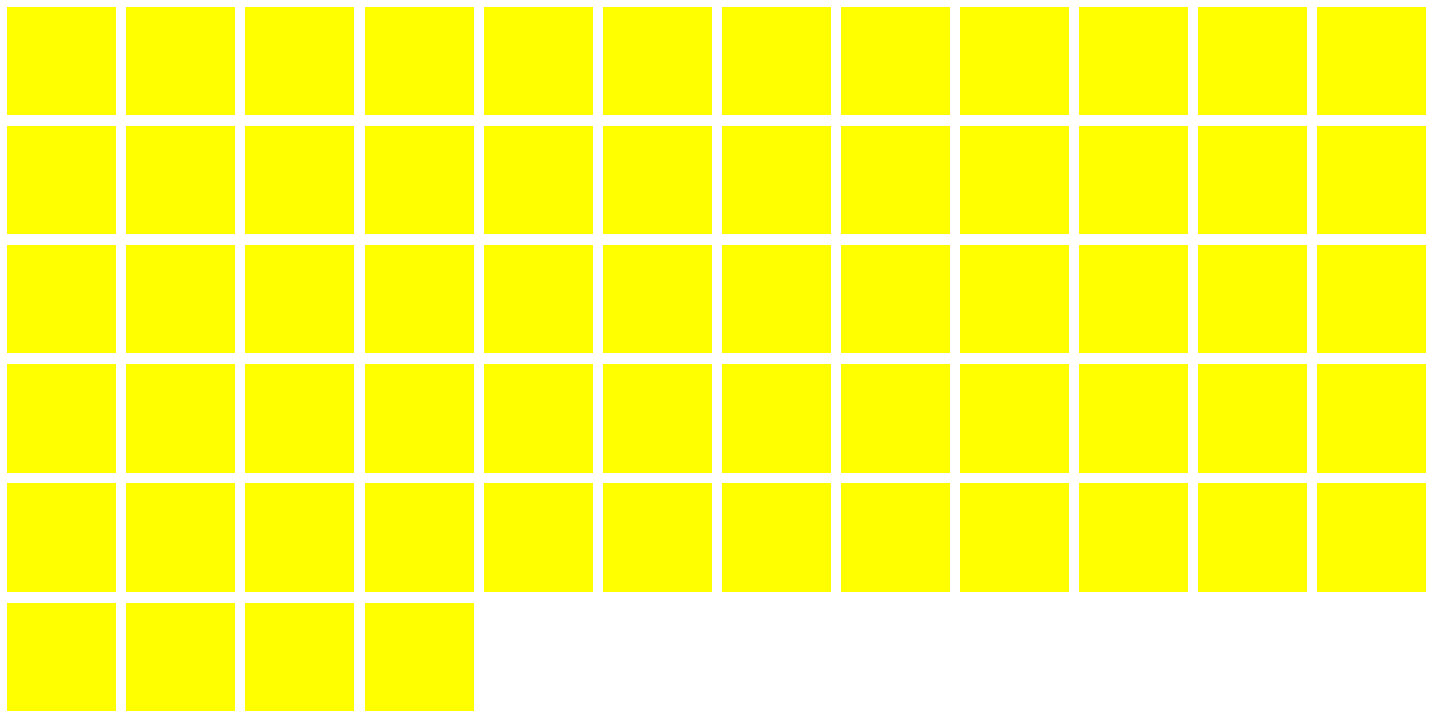

Epoch 11
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


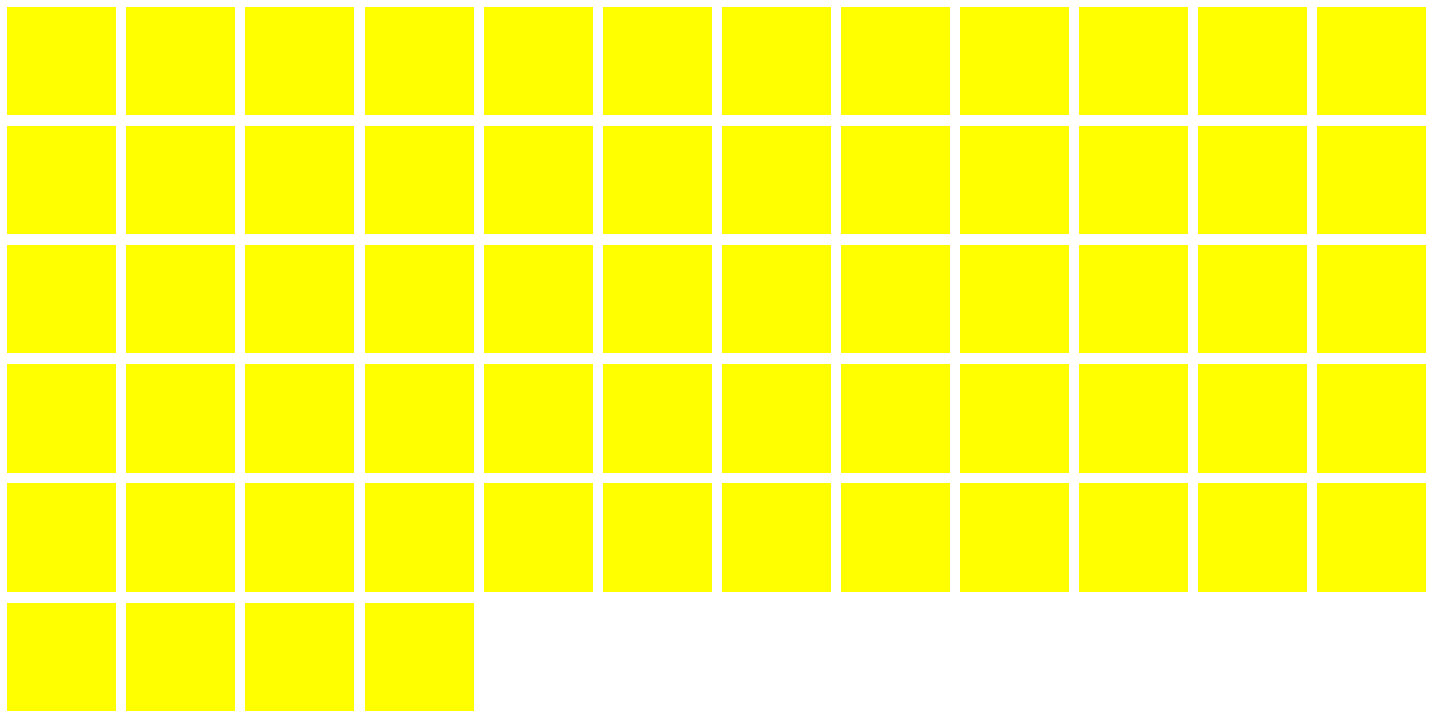

Epoch 12
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


KeyboardInterrupt: 

In [19]:


training(1000)